In [1]:
import pandas as pd
import pickle
from urllib.request import urlopen
import matplotlib.pyplot as plt
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.results as res
from biogeme.expressions import Beta, bioDraws, MonteCarlo

The following function obtains the data from the file available online.

In [2]:
url_root = (
    'https://courses.edx.org/'
    'asset-v1:EPFLx+ChoiceModels2x+3T2021+type@asset+block@'
)

In [3]:
def get_results_from_url(file):
    pickle_file = f'{url_root}{file}'

    with urlopen(pickle_file) as p:
        data = pickle.load(p)
    return res.bioResults(data)

# Read the data

In [4]:
df = pd.read_table(f'{url_root}swissmetro.dat')
database = db.Database('swissmetro', df)
globals().update(database.variables)
exclude = ((PURPOSE != 1) * (PURPOSE != 3) + (CHOICE == 0)) > 0
database.remove(exclude)

# List of parameters to be estimated

In [5]:
ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 0)
ASC_SM = Beta('ASC_SM', 0, None, None, 1)
B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_TIME_S = Beta('B_TIME_S', 1, None, None, 0)
B_TIME_RND = B_TIME + B_TIME_S * bioDraws('B_TIME_RND', 'NORMAL')

# Definition of variables

In [6]:
SM_COST = SM_CO * (GA == 0)
TRAIN_COST = TRAIN_CO * (GA == 0)
CAR_AV_SP = CAR_AV * (SP != 0)
TRAIN_AV_SP = TRAIN_AV * (SP != 0)
TRAIN_TT_SCALED = TRAIN_TT / 100
TRAIN_COST_SCALED = TRAIN_COST / 100
SM_TT_SCALED = SM_TT / 100
SM_COST_SCALED = SM_COST / 100
CAR_TT_SCALED = CAR_TT / 100
CAR_CO_SCALED = CAR_CO / 100
TRAIN_HE_SCALED = TRAIN_HE / 1000
SM_HE_SCALED = SM_HE / 1000
LOW_INC = INCOME <= 1
BUSINESS = (PURPOSE == 3)

# Utility functions and availability condition

In [7]:
V1 = (ASC_TRAIN +
      B_TIME_RND * TRAIN_TT_SCALED +
      B_COST * TRAIN_COST_SCALED)
V2 = (B_TIME_RND * SM_TT_SCALED +
      B_COST * SM_COST_SCALED)
V3 = (ASC_CAR +
      B_TIME_RND * CAR_TT_SCALED +
      B_COST * CAR_CO_SCALED)

V = {1: V1,
     2: V2,
     3: V3}

av = {1: TRAIN_AV_SP,
      2: SM_AV,
      3: CAR_AV_SP}

# Results of the estimation

If the estimation has already been made, the results are read from the file. If not, estimation is performed. It may take a while. 

In [8]:
results = get_results_from_url(f'swissmetroRandomCoefficients.pickle')

In [9]:
results.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-0.984734,0.034848,-28.258202,0.000000,0.033608,-29.300813,0.000000
ASC_TRAIN,-1.505986,0.046929,-32.090459,0.000000,0.046043,-32.708387,0.000000
B_COST,-0.662681,0.042402,-15.628515,0.000000,0.048266,-13.729648,0.000000
B_TIME,-0.140265,0.035929,-3.903931,0.000095,0.032522,-4.312954,0.000016
B_TIME_S,0.099318,0.077782,1.276874,0.201647,0.063169,1.572266,0.115889


# Simulation

The distribution of the random parameter $\beta$ for individuals with configuration $(i, x)$ is given by 
$$
h(\beta|i,x,\theta) = \frac{P(i|x,\beta) f(\beta|\theta)}{
  P(i|x,\theta)} = \frac{P(i|x,\beta) f(\beta|\theta)}{
  \int P(i|x,\beta) f(\beta|\theta) d\beta}.
$$
The expected value of the parameter is given by
$$
\bar{\beta} = \int \beta \,h(\beta|i,x,\theta) d\beta= \frac{\int \beta\, P(i|x,\beta) f(\beta|\theta) d\beta}{
  \int P(i|x,\beta) f(\beta|\theta) d\beta}.
$$


The choice probability $P(i|x,\beta)$, conditional on $\beta$, is calculated as follows.

In [10]:
prob_chosen = models.logit(V, None, CHOICE)

The numerator $$\int \beta\, P(i|x,\beta) f(\beta|\theta) d\beta$$ is calculated as follows.

In [11]:
numerator = MonteCarlo(B_TIME_RND * prob_chosen)

The denominator $$\int P(i|x,\beta) f(\beta|\theta) d\beta$$ is calculated as follows.

In [12]:
denominator = MonteCarlo(prob_chosen)

These quantities are calculated for each indivual in the sample using Biogeme in simulation mode.

In [13]:
simulate = {'Numerator': numerator,
            'Denominator': denominator,
            'Choice': CHOICE}

In [14]:
biosim = bio.BIOGEME(database, simulate, numberOfDraws=1000)

In [15]:
sim = biosim.simulate(results.getBetaValues())

Finally, the value itself is calculated by dividing the numerator by the denominator.

In [16]:
sim['Individual-level parameters'] = sim['Numerator'] / sim['Denominator']

We investigate these quantities for each market segment.

In [17]:
Train = sim[sim.Choice == 1]
Car = sim[sim.Choice == 3]
SM = sim[sim.Choice == 2]

In [18]:
Train.describe()

,Numerator,Denominator,Choice,Individual-level parameters
count,908.000000,908.000000,908.0,908.000000
mean,-0.017800,0.132548,1.0,-0.134071
std,0.002232,0.014219,0.0,0.004729
min,-0.024688,0.046552,1.0,-0.150151
25%,-0.019380,0.125416,1.0,-0.137274
50%,-0.017852,0.131762,1.0,-0.134478
75%,-0.016655,0.142059,1.0,-0.131379
max,-0.006426,0.175070,1.0,-0.115098


In [19]:
Car.describe()

,Numerator,Denominator,Choice,Individual-level parameters
count,1770.000000,1770.000000,1770.0,1770.000000
mean,-0.040691,0.293061,3.0,-0.138621
std,0.012098,0.085550,0.0,0.005815
min,-0.098226,0.018683,3.0,-0.157842
25%,-0.048626,0.235375,3.0,-0.141875
50%,-0.038352,0.275630,3.0,-0.138900
75%,-0.032585,0.350952,3.0,-0.135791
max,-0.002379,0.692281,3.0,-0.027610


In [20]:
SM.describe()

,Numerator,Denominator,Choice,Individual-level parameters
count,4090.000000,4090.000000,4090.0,4090.000000
mean,-0.087765,0.616480,2.0,-0.142279
std,0.011656,0.077849,0.0,0.004019
min,-0.115892,0.040640,2.0,-0.155298
25%,-0.094935,0.591093,2.0,-0.144953
50%,-0.089468,0.627920,2.0,-0.142242
75%,-0.083216,0.662582,2.0,-0.139745
max,-0.006090,0.818925,2.0,-0.112667


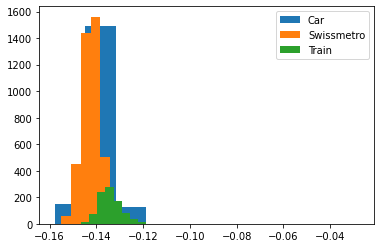

In [21]:
Car['Individual-level parameters'].hist(ax=plt.gca(), label='Car', grid=False)
SM['Individual-level parameters'].hist(ax=plt.gca(), label='Swissmetro', grid=False)
Train['Individual-level parameters'].hist(ax=plt.gca(), label='Train', grid=False)
plt.legend()
plt.show()

## Zoom

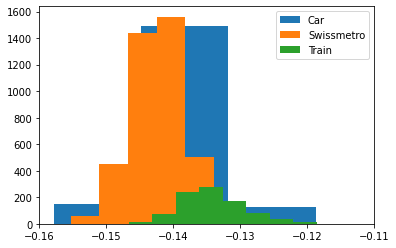

In [22]:
Car['Individual-level parameters'].hist(ax=plt.gca(), label='Car', grid=False)
SM['Individual-level parameters'].hist(ax=plt.gca(), label='Swissmetro', grid=False)
Train['Individual-level parameters'].hist(ax=plt.gca(), label='Train', grid=False)
plt.legend()
plt.xlim([-0.16, -0.11])
plt.show()

It seems that individuals who selected Swissmetro have a more negative travel time coefficient.